In [2]:
import os
import sys
import numpy as np
import sympy as sp
import torch as pt
from torch.nn.functional import normalize
import scipy
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import logging
import sys
from torch.utils.data import TensorDataset, DataLoader
from torch.func import hessian, vmap
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = pt.device("cuda" if pt.cuda.is_available() else "cpu")

sys.path.append(os.path.abspath('../'))

from src.useful_functions import *
from src.PWDs_module import generate_PWDistances_torch
from src.sqra_functions import*
from src.openmm_functions import*
from src.isokann_modules2 import*
# For reproducibility
np.random.seed(0)


# Read directory paths
read_dirs_paths('dir_paths_.txt', globals())



 
Created variables:
inp_dir = /scratch/htc/fsafarov/structures/8ef5_july_2025/8ef5/
dcd_dir = /scratch/htc/fsafarov/mOR_dcd_files/npat/
out_dir = /scratch/htc/fsafarov/ISOKANN_PINN/output/


In [2]:
psf_file = 'step5_assembly.psf'
crd_file = 'step5_assembly.crd'

system, psf, crd = setup_system(
                    inp_dir,
                    ligand_name = '7V7',
                    nbcutoff = 1.0,
                    psf_file=psf_file,
                    crd_file=crd_file  
                )


dcd_file = 'mOR_simulation_NPAT_CA_aligned.dcd'
dt=2.0
gamma=1.0
T=310.15
platform='CUDA'


forces = get_parameters(
                        system,
                        inp_dir,
                        dcd_file,
                        dcd_dir,
                        dt, #in femtoseconds
                        T,
                        gamma,
                        platform,
                        pdb_file='step5_assembly.pdb',
                        integrator_type='Langevin',
                        psf=psf,
                        get_potential_grad=True
                        
                      )


Number of atoms in the system: 118294


/scratch/htc/fsafarov/openmm_ff/lib/python3.12/site-packages/openmm/app/charmmparameterset.py:391: UserWarning: Replacing dihedral <DihedralType: k=0.27; phase=180.0; per=2> with <DihedralType: k=0.03; phase=180.0; per=2>
  warnings.warn('Replacing dihedral %r with %r' %
/scratch/htc/fsafarov/openmm_ff/lib/python3.12/site-packages/openmm/app/charmmparameterset.py:391: UserWarning: Replacing dihedral <DihedralType: k=0.0; phase=0.0; per=3> with <DihedralType: k=0.12; phase=0.0; per=3>
  warnings.warn('Replacing dihedral %r with %r' %


dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


In [3]:
ca_indices = select(psf=psf,selection="protein and name CA")
forces_ = np.linalg.norm(forces, axis=-1)

forces_ = forces_[:, ca_indices]


In [4]:
coords = get_parameters(
                        system,
                        inp_dir,
                        dcd_file,
                        dcd_dir,
                        dt, #in femtoseconds
                        T,
                        gamma,
                        platform,
                        pdb_file='step5_assembly.pdb',
                        integrator_type='Langevin',
                        psf=psf,
                        get_coords=True
                      )

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


In [5]:
positions = np.linalg.norm(coords, axis=-1)
positions = positions[:, ca_indices]

In [6]:
forces_ = pt.Tensor(forces_)
positions = pt.Tensor(positions)

In [ ]:
pt.save(forces_, os.path.join(out_dir, 'forces_mor_ca.pt'))
pt.save(positions, os.path.join(out_dir, 'positions_mor_ca.pt'))

In [7]:
mean_forces = forces_.mean(dim=-1, keepdim=True)
std_forces = forces_.std(dim=-1, keepdim=True)
forces_normalized = (forces_ - mean_forces)/(std_forces + 1e-8)

In [8]:
inp_dim = positions.shape[-1]
nodes = [inp_dim, 256, 128, 64, 1] 
base_mlp = MLP(nodes, act_fun='gelu')

In [9]:
model = ratesNN(base_mlp)
optimizer = pt.optim.SGD(model.parameters(), lr=1e-5, weight_decay=1e-5, momentum=0.85, nesterov=True)
D=2.5

trained_model = trainNN(
    model=model, 
    coords=positions.to(device), 
    forces_fn=forces_normalized.to(device), 
    batch_size=500,
    optimizer=optimizer, 
    Nepochs=1500,
    lam_bound=0.1,
    device=device
)

epoch   0 | loss 46.522679 |
epoch 125 | loss 0.000802 |
epoch 250 | loss 0.000806 |
epoch 375 | loss 0.000822 |
epoch 500 | loss 0.000790 |
epoch 625 | loss 0.000788 |
epoch 750 | loss 0.000781 |
epoch 875 | loss 0.000799 |
epoch 1000 | loss 0.000834 |
epoch 1125 | loss 0.000785 |
epoch 1250 | loss 0.000782 |
epoch 1375 | loss 0.000776 |
epoch 1500 | loss 0.000790 |


In [10]:
with pt.no_grad():
    chi = model(positions.to(device))

del model

In [11]:
def scale_and_shift(y):
    minarr = pt.min(y)
    maxarr = pt.max(y)
    hat_y =  (y - minarr) / (maxarr - minarr)

    return hat_y

chi_s = scale_and_shift(chi)
chi_s = chi_s.cpu().detach().numpy()

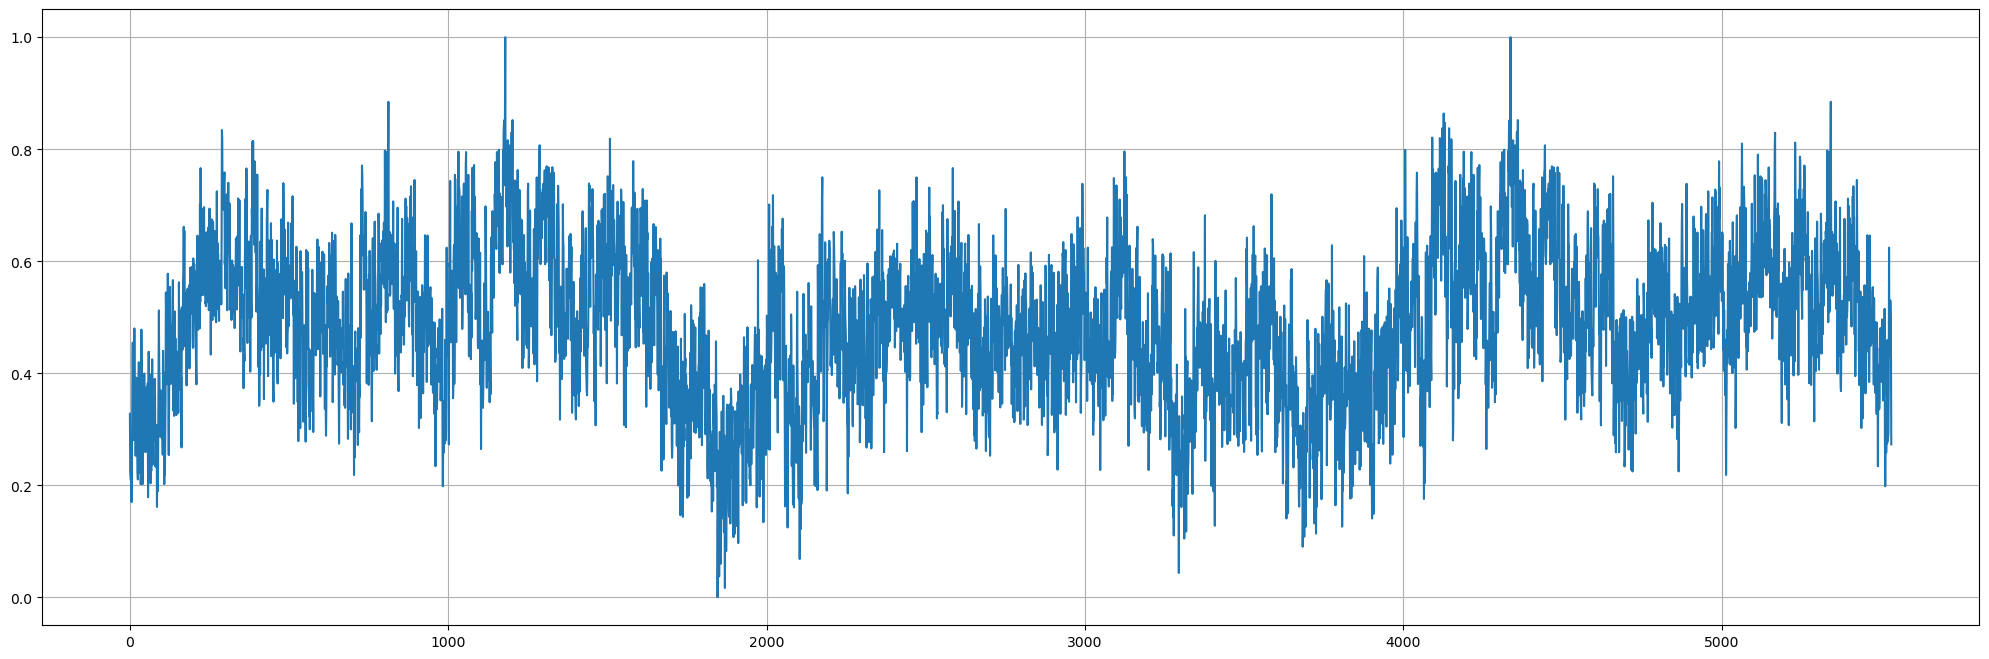

In [12]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(25,8))
plt.plot(chi_s)
plt.grid()

In [13]:
np.savetxt(os.path.join(out_dir, 'chi_mor_1.txt'), chi_s)

In [14]:
del forces_normalized

In [15]:
del positions

In [3]:
chi0 = np.loadtxt(os.path.join(out_dir, 'chi_mor_0.txt'))
chi1 = np.loadtxt(os.path.join(out_dir, 'chi_mor_1.txt'))

In [4]:
chi_m = np.array([chi0, chi1])

In [5]:
from scipy.linalg import svd
U, S, V = svd(chi_m)

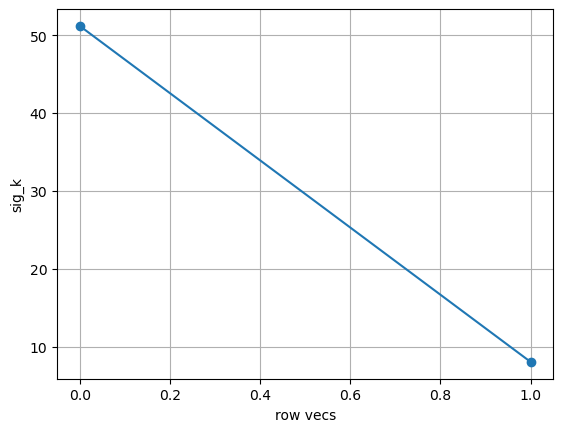

In [7]:
import matplotlib.pyplot as plt
plt.plot(S, 'o-')
plt.xlabel('row vecs')
plt.ylabel('sig_k')
plt.grid()

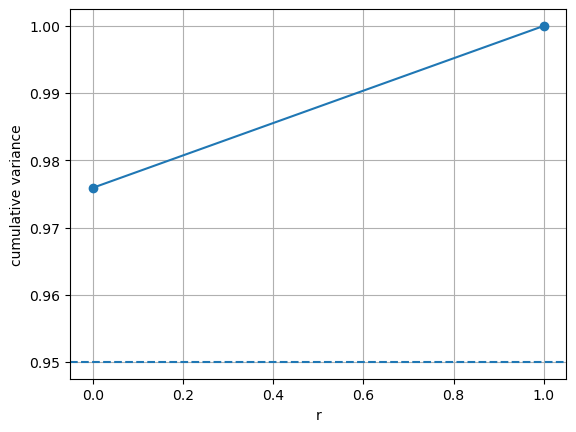

In [8]:
varfrac = (S**2)/np.sum(S**2)
plt.plot(np.cumsum(varfrac), 'o-'); plt.axhline(0.95, ls='--');
plt.xlabel('r')
plt.ylabel('cumulative variance')
plt.grid()